## BnB DFS ##

In [28]:
import numpy as np
import random 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import math


def DFS(dist_mat, heuristic = "NN", cluster = False, n_clusters = 3, h_freq = 3, max_bottoms = 10**2, opt_iter = 10**2, mean = 100, sigma = 100):
    
    # dist_mat: nxn symmetric numpy array 
    # heuristic: "NN" or "2opt"
    # cluster: True for clustered subproblems
    # n_clusters: number of sub problems to split into
    # max_bottoms: stopping criteria - number of times we've reached the bottom
    # opt_iter: stopping criterion for 2opt
    
    inf = math.inf # initial upper bound
    bestcost_array = []
    total_approx = []
    heuristic_array = []
    current_cost_array = []
    bound_array = []
    best_path = []
    best_dist = 0
    iter = 0
    bottoms = 0
    
    N = len(dist_mat)
    
    # 2-opt heuristic function
    def two_opt (sub_path, sub_problem):
                
        # special cost function for 2opt
        def cost_func(state, matrix):
            cost = 0 
            for i in range(len(state) - 1):
                cost += matrix.loc[state[i], state[i+1]]      
            return cost
        
        # exchange 2 edges
        def switch_two(state, pivot, temp, i):
            state[pivot], state[temp[i]] = state[temp[i]], state[pivot]
            return state 
        
        # reset index on state + matrix
        sub_problem = pd.DataFrame(pd.DataFrame(sub_problem).to_numpy())
        sub_path = [i for i in range(len(sub_path))]
        
        # initialize
        new_state = sub_path
        current_cost = cost_func(new_state, sub_problem)
        
        if len(sub_path) == 0:
            return 0
        
        # begin 2-opt algorithm
        for j in range(opt_iter):

            state = new_state
            pivot = random.choice(new_state) # index of pivot node   
            temp = [k for k in new_state if k != pivot]
            
            # switch edges uses pivot with every other node
            for i in range(len(temp)):

                opt = switch_two(state, pivot, temp, i)    
                opt_cost = cost_func(opt, sub_problem)
                
                if opt_cost < current_cost:
                    current_cost = opt_cost
                    new_state = opt # improved tours are used in the next round

        return current_cost
    
    # cluster: create subproblems
    def cluster_heuristic(state):

        unexpanded_nodes, unexpanded_matrix = future_path(state)
        
        kmeans = KMeans(n_clusters = n_clusters, random_state = 1999).fit(unexpanded_matrix.to_numpy()) # kmeans cluster
        clusters = kmeans.labels_ # cluster labels vec

        h = 0
        
        # solve each subproblem separately grouped by kmeans partition
        for i in range(n_clusters):
            
            sub_path = [j for j in unexpanded_nodes if clusters[j] == i] # subpath of nodes in cluster i
            sub_problem = unexpanded_matrix.take(sub_path, axis=0) # subset matrix for subpath
            sub_problem = sub_problem.take(sub_path, axis=1)
            
            # rarely clusters will be empty
            if sub_path == []:
                return h

            # track and connect paths between clusters
            if i != 0 and i != n_clusters-1:
                h += dist_mat.loc[sub_path_end, sub_path[0]]
            sub_path_end = sub_path[-1]
            
            # there are issues if subpaths are too small
            if len(sub_problem) < 3:
                h += mean
                
            # solve sub problem and add on subpath distance
            else:
        
                # have to reset indices on sub problem
                sub_problem = pd.DataFrame(pd.DataFrame(sub_problem).to_numpy())
                sub_path = pd.DataFrame(sub_path)
                
                if heuristic == '2opt':
                    sub_path_dist = two_opt(sub_path, sub_problem)
                elif heuristic == 'NN':
                    sub_problem = [i for i in state if i not in sub_problem]
                    sub_path_dist = NN(sub_problem)
                    
                h += sub_path_dist
            
        return h
            
        
    def NN(state):
        
        dist_mat_tilde = pd.DataFrame(dist_mat).copy().to_numpy()
                
        dist_mat_tilde[state[:-1]] = inf
        dist_mat_tilde[:,state[:-1]] = inf
        np.fill_diagonal(dist_mat_tilde, inf)
        
        cost = 0
        next = state[-1]
        NN_iter = 0

        while NN_iter <= N - len(state) - 1:

            ind = dist_mat_tilde[next,:].argmin() # city with min dist from current
            cost_new = dist_mat_tilde[next,ind]
            dist_mat_tilde[:,next] = inf
            
            cost += cost_new
            next = ind
            NN_iter += 1
            
        cost + dist_mat.loc[next, state[0]]
        
        return cost
    
    # return unexplored nodes and corresponding matrix entries
    def future_path(state):
                
        full_nodes = [i for i in range(N)] # full node list

        # cluster on unexpanded nodes
        unexpanded_nodes = [i for i in full_nodes if i not in state] # nodes left to explore
        unexpanded_matrix = dist_mat.take(unexpanded_nodes, axis=0) # subset dist matrix by unexpanded nodes
        unexpanded_matrix = unexpanded_matrix.take(unexpanded_nodes, axis=1)
        unexpanded_nodes = [i for i in range(len(unexpanded_nodes))] # relabel since there is no need to retain this info anymore
        sub_problem = pd.DataFrame(pd.DataFrame(unexpanded_matrix).to_numpy())
        sub_path = pd.DataFrame(unexpanded_nodes)
        
        return sub_path, sub_problem
        
    # calculates current cost + heuristic (approximation of future cost)
    def objective_function(state, calculate_heuristic):
                        
        if len(state) < 2:
            return U

        if calculate_heuristic:
            # calculate heuristic using clustering
            if cluster == True:
                if len(state) <= n_clusters: # don't cluster unless the unexplored path is long enough
                    h = cluster_heuristic(state)       
                elif heuristic == '2opt' and len(state) > 2:
                    unexpanded_nodes, unexpanded_matrix = future_path(state)
                    h = two_opt(unexpanded_nodes, unexpanded_matrix)
                else:
                    h = NN(state)
                    
            # calculate heuristic whole
            elif cluster == False:

                if heuristic == "2opt":        
                    unexpanded_nodes, unexpanded_matrix = future_path(state)
                    h = two_opt(unexpanded_nodes, unexpanded_matrix)

                elif heuristic == "NN":
                    h = NN(state)   
                    
        # no heuristic            
        elif not calculate_heuristic:
            h = (N - len(state))*(mean + sigma//2)

        cost = 0

        for i in range(len(state) - 1):
            cost += dist_mat.loc[state[i], state[i+1]]
            
        # we are at the end    
        if len(state) == len(dist_mat):
            cost += dist_mat.loc[state[-1], state[0]]
        
        cost_approx = cost + h
        
        heuristic_array.append(h)
        current_cost_array.append(cost)
        total_approx.append(cost_approx)

        return cost_approx
    
    # appends newly generated nodes to frontier
    def gen_front(current, frontier, N):

        nums = [i for i in range(N)]
        
        for y in current:
            if y in nums:
                nums.remove(y)
        for i in range(len(nums)):
            t = current[:]
            t.append(nums[i])
            frontier.append(t)
        return frontier

    frontier = [[i] for i in range(N)]  
    
    # U = inf # initial bound 
   # U = 0
   # for i in range(N - N//(sigma//mean)):
   #     U += abs(np.random.normal(mean, sigma, 1))

    U = NN([i for i in range(N)]) + N*sigma

    calculate_heuristic = True
    
    while frontier != [] and bottoms < max_bottoms:

        
        new_path = frontier.pop()
        
        if iter % h_freq == 0:
            calculate_heuristic = False
                
        path_cost = objective_function(new_path, calculate_heuristic)
        calculate_heuristic = True
        
        if path_cost > U:
            continue
        
        # we have a complete path    
        elif len(new_path) == N:
            U = path_cost
            best_path = new_path
            best_dist = path_cost
            bestcost_array.append(path_cost)
            best_path.append(0)
            bottoms += 1
            
        else:
            frontier = gen_front(new_path, frontier, N)
        
        bound_array.append(U)
        iter += 1

    # Plots      
    fig, axes = plt.subplots(1, 3, figsize=(12, 5))
    fig.tight_layout(pad = 5)   
    
    plt.subplot(1, 3, 1)
    plt.plot(bestcost_array)
    plt.title('Progression path cost')
    plt.ylabel('Cost')
    plt.xlabel('Iteration')
  
    plt.subplot(1, 3, 2)
    plt.plot(bound_array)
    plt.title('Upper-bound')
    plt.ylabel('Cost Bound')
    plt.xlabel('Iteration')    

    plt.subplot(1, 3,3)
    plt.plot(total_approx, label = "f + h")
    plt.plot(current_cost_array, label = "f")
    plt.plot(heuristic_array, label = "h")
    plt.legend()
    plt.show()
    
    return best_path, best_dist

import numpy as np
import pandas as pd
from python_tsp.exact import solve_tsp_dynamic_programming
from python_tsp.heuristics import solve_tsp_local_search

def write_distance_matrix(n, mean, sigma):
    distance_matrix = np.zeros((n, n))
    random_distance = []
    num_distance = int(n * (n-1) / 2)
    for _ in range(num_distance):
        distance = 0
        while distance <= 0:
            distance = np.random.normal(mean, sigma)

        random_distance.append(round(distance))
    
    iu = np.triu_indices(n, 1)
    distance_matrix[iu] = random_distance
    distance_matrix += distance_matrix.T

    return distance_matrix
    

mean = 10
sigma = 1000
N = 20
h_freq = 50
n_clusters = N//5
opt_iter = 10**1
max_bottoms = N

distance_matrix = pd.DataFrame(write_distance_matrix(N, mean, sigma))

path, dist = DFS(distance_matrix, heuristic = "2opt", cluster = True, n_clusters = n_clusters, h_freq = h_freq, max_bottoms = max_bottoms, opt_iter = opt_iter)

permutation, distance = solve_tsp_local_search(distance_matrix.to_numpy())
#solve_tsp_local_search #heuristic, approx
#solve_tsp_dynamic_programming #optimal
print("Ours vs optimal", dist, distance )

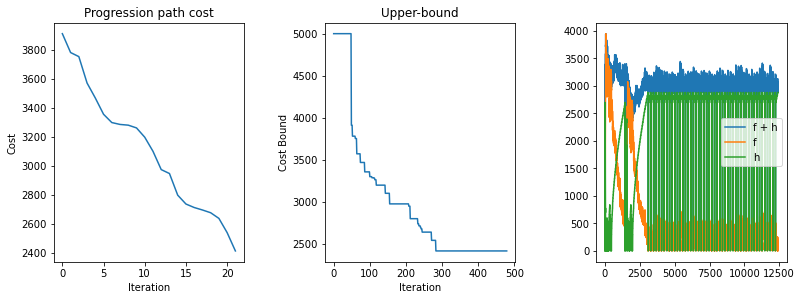

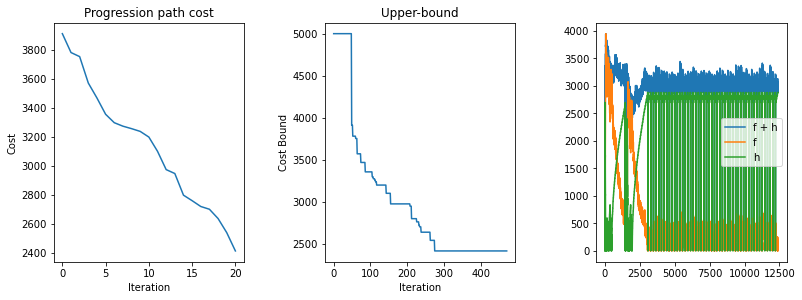

Ours vs optimal 2414.0 421.0


In [30]:
import numpy as np
import pandas as pd
from python_tsp.exact import solve_tsp_dynamic_programming
from python_tsp.heuristics import solve_tsp_local_search

def write_distance_matrix(n, mean, sigma):
    distance_matrix = np.zeros((n, n))
    random_distance = []
    num_distance = int(n * (n-1) / 2)
    for _ in range(num_distance):
        distance = 0
        while distance <= 0:
            distance = np.random.normal(mean, sigma)

        random_distance.append(round(distance))
    
    iu = np.triu_indices(n, 1)
    distance_matrix[iu] = random_distance
    distance_matrix += distance_matrix.T

    return distance_matrix

RUNS = 2
path_arr = []
dist_arr = []

mean = 10
sigma = 100
N = 50
h_freq = 4
n_clusters = N//4
opt_iter = 10**1
max_bottoms = 2*N

distance_matrix = pd.DataFrame(write_distance_matrix(N, mean, sigma))

for i in range(RUNS):
    path, dist = DFS(distance_matrix, heuristic = "2opt", cluster = True, n_clusters = n_clusters, h_freq = h_freq, max_bottoms = max_bottoms, opt_iter = opt_iter, mean = mean, sigma = sigma)
    path_arr.append(path)
    dist_arr.append(dist)
    
permutation, distance = solve_tsp_local_search(distance_matrix.to_numpy())
#solve_tsp_local_search #heuristic, approx
#solve_tsp_dynamic_programming #optimal
print("Ours vs optimal", min(dist_arr), distance )
